#### 캐글 신용카드 사기 검출

- https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

- 이 데이터셋의 레이블 class 속성은 매우 불균형한 분포를 가짐

- class는 0이 정상 거래, 1이 사기 거래

- 전체 데이터의 0.172%만이 사기 거래인 1임

##### 언더 샘플링과 오버 샘플링의 이해

- 이상 레이블보다 정상 레이블 수가 매우 많이 때문에 일방적으로 정상 레이블로 치우친 학습을 수행하게돼서 이상 데이터 검출이 어려움

<적절한 학습 데이터를 확보하는 방안>

1. 오버 샘플링(Oversampling) >> 더 많이 사용

- 적은 데이터셋을 증식시키는 것, 동일한 데이터를 단순히 증식시키면 과적합 위험이 있으므로 피처값을 약간만 변형시켜서 증식시킴

- SMOTE: 적은 데이터셋의 개별 데이터들의 K최근접 이웃을 찾아서 해당 데이터와 K개 이웃의 차이를 일정값으로 만들어 약간만 차이나게 새로운 데이터를 생성하는 방식

  imbalanced-learn 패키지

2. 언더 샘플링(Undersampling)

- 많은 데이터셋을 적은 데이터셋 수준으로 감소시키는 것

  ex) 정상 1000개, 이상 100개 있으면 정상도 100개로 줄임


##### 데이터 1차 가공 및 모델 학습, 예측, 평가

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

card_df = pd.read_csv('/content/creditcard.csv')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


- V로 시작하는 피처의 의미는 모름

- time: 데이터 생성 관련 작업용 속성이라 의미없음 >> 제거

- Amount: 신용카드 거래 금액

In [2]:
card_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

- 결측치 없고 Class 레이블만 int형

- 다양한 데이터 가공을 해보기 위해 DataFrame을 복사하고 이를 가공하여 반환하는 함수를 생성하자

- 그리고 불필요한 time 피처만 삭제하는 함수도 생성

In [3]:
from sklearn.model_selection import train_test_split

def get_preprocessed_df(df=None):
  df_copy = df.copy()
  df_copy.drop('Time', axis=1, inplace=True)
  return df_copy

det_train_test_dataset 함수는 get_preprocessed_df를 호출하고 내부에서 train_test_split 함수를 호출함

테스트데이터셋을 전체의 30%인 stratified 방식으로 추출해 학습, 테스트데이터셋 간의 분포를 동일하게 만들어줌

In [23]:
def get_train_test_dataset(df=None):
  df_copy = get_preprocessed_df(df)
  X_features = df_copy.iloc[:, :-1]
  y_target = df_copy.iloc[:, -1]
  X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)

  return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [5]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0] * 100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0] * 100)

학습 데이터 레이블 값 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64
테스트 데이터 레이블 값 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64


- 큰 차이없이 잘 분할됌

###### 로지스틱 회귀

In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve

def get_clf_eval(y_test, pred, pred_proba):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}, AUC: {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [7]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=1000)
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차 행렬
[[85281    14]
 [   57    91]]
정확도: 0.9992, 정밀도: 0.8667, 재현율: 0.6149, F1:0.7194, AUC: 0.9704


###### LightGBM

- 앞으로 수행할 코드에서 반복적으로 모델을 변경할 것이므로 이를 위한 별도의 함수를 생성하자

In [8]:
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
  model.fit(ftr_train, tgt_train)
  pred = model.predict(ftr_test)
  pred_proba = model.predict_proba(ftr_test)[:, 1]
  get_clf_eval(tgt_test, pred, pred_proba)

- 이 데이터는 극도로 불균형한 레이블 분포를 가지고 있으므로 LightGBMClassifier에 boost_from_average=False라는 파라미터를 설정해야함

In [9]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1,  boost_from_average=False)

get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

오차 행렬
[[85290     5]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568, F1:0.8453, AUC: 0.9790


- 로지스틱 회귀보다는 높은 재현율을 나타냄

##### 데이터 분포도 변환 후 모델 학습, 예측, 평가

- 데이터를 재가공해보고 다시 모델을 테스트해보자

중요 피처값의 분포도를 살펴보기

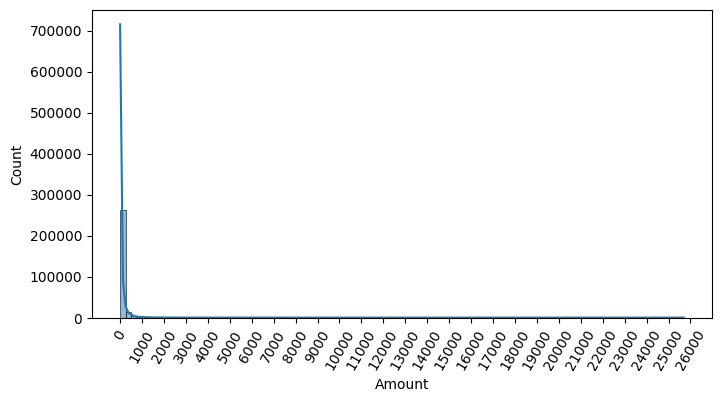

In [10]:
import seaborn as sns

plt.figure(figsize=(8,4))
plt.xticks(range(0, 30000, 1000), rotation=60)
sns.histplot(card_df['Amount'], bins=100, kde=True)
plt.show()

카드 사용 금액이 1000불 이하인 데이터가 대부분임

드물지만 26000불까지 많은 금액을 사용한 경우가 있음


-  StandardScaler를 이용하여 Amount 피처값을 표준정규분포 형태로 변환하자

In [29]:
from sklearn.preprocessing import StandardScaler

def get_preprocessed_df(df=None):
  df_copy = df.copy()
  scaler= StandardScaler()
  amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1, 1))
  df_copy.insert(0, 'Amount_Scaled', amount_n)
  df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
  return df_copy

In [30]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('## 로지스틱 회귀 예측 성능 ##')
lr_clf = LogisticRegression(max_iter=1000)
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('## LightGBM 예측 성능 ##')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

## 로지스틱 회귀 예측 성능 ##
오차 행렬
[[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081, F1:0.7143, AUC: 0.9702
## LightGBM 예측 성능 ##
오차 행렬
[[85290     5]
 [   37   111]]
정확도: 0.9995, 정밀도: 0.9569, 재현율: 0.7500, F1:0.8409, AUC: 0.9779


로지스틱 회귀는 정밀도, 재현율이 오히려 좀 떨어졌고
LightGBM도 약간 떨어졌지만 성능상의 변경은 크게 없음

- 로그 변환을 사용하여 데이터 분포도 왜곡을 개선해보자 >> numpy log1p()함수를 이용 

In [24]:
def get_preprocessed_df(df=None):
  df_copy = df.copy()
  amount_n = np.log1p(df_copy['Amount'])
  df_copy.insert(0, 'Amount_Scaled', amount_n)
  df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
  return df_copy

In [25]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('## 로지스틱 회귀 예측 성능 ##')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('## LightGBM 예측 성능 ##')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

## 로지스틱 회귀 예측 성능 ##
오차 행렬
[[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014, F1:0.7149, AUC: 0.9727
## LightGBM 예측 성능 ##
오차 행렬
[[85290     5]
 [   35   113]]
정확도: 0.9995, 정밀도: 0.9576, 재현율: 0.7635, F1:0.8496, AUC: 0.9796


로지스틱 회귀은 재현율이 떨어짐

LightGBM은 재현율이 올라감

> 레이블이 극도로 불균일한 데이터셋에서 로지스틱 회귀는 데이터 변환시 불안정함

##### 이상치 제거 후 모델 학습, 예측, 평가

- 이상치를 찾는 방법
 
 IQR 방식: 사분위값의 편차를 이용하는 기법으로 Box Plot으로 시각화할 수 있음

 Q1 - IQR * 1.5 <= x <= Q3 + IQR * 1.5 를 벗어나면 이상치로 간주

- 어떤 피처의 이상치 데이터를 검출할 것인지 선택해야함
  
  → 결정값과 가장 상관성이 높은 피처 위주로

<Axes: >

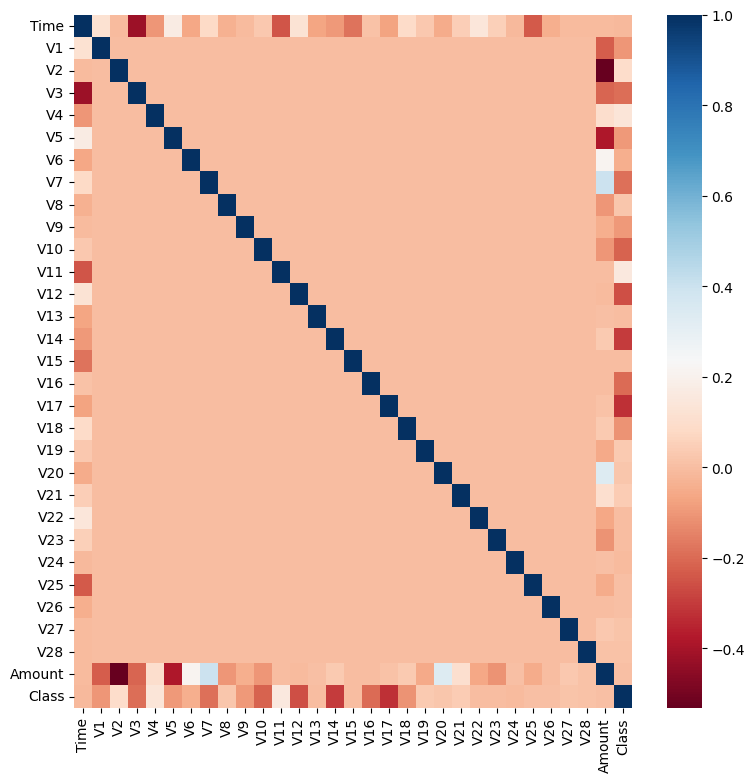

In [17]:
import seaborn as sns

plt.figure(figsize=(9,9))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu')

- class와 상관이 높은 피처는 V14, V17이다.

- 이중에서 V14만 이상치를 찾아서 제거해보자

- 이상치를 반환하는 함수 생성

In [26]:
from dask.dataframe.core import quantile
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):

  #fraud에 해당하는 칼럼데이터만 추출, 1/4분위와 3/4분위 지점을 np.percentile로 구함
  fraud = df[df['Class']==1][column]
  quantile_25 = np.percentile(fraud.values, 25)
  quantile_75 = np.percentile(fraud.values, 75)

  iqr = quantile_75 - quantile_25
  iqr_weight = iqr * weight
  lowest_val = quantile_25 - iqr_weight
  highest_val = quantile_75 + iqr_weight

  outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index

  return outlier_index

In [27]:
outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print('이상치 데이터 인덱스:', outlier_index)

이상치 데이터 인덱스: Int64Index([8296, 8615, 9035, 9252], dtype='int64')


- 이상치를 삭제하는 로직을 get_processed_df함수에 추가하기

책이랑 결과 다르게 나옴

In [28]:
def get_processed_df(df=None):
  df_copy = df.copy()
  amount_n = np.log1p(df_copy['Amount'])
  df_copy.insert(0, 'Amount Scaled', amount_n)
  df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)

  #이상치 데이터 삭제하는 로직 추가
  outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
  df_copy.drop(outlier_index, axis=0, inplace=True)
  return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print('## 로지스틱 회귀 예측 성능 ##')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)
print('##  LightGBM 예측 성능 ##')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

## 로지스틱 회귀 예측 성능 ##
오차 행렬
[[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014, F1:0.7149, AUC: 0.9727
##  LightGBM 예측 성능 ##
오차 행렬
[[85290     5]
 [   35   113]]
정확도: 0.9995, 정밀도: 0.9576, 재현율: 0.7635, F1:0.8496, AUC: 0.9796


##### SMOTE 오버 샘플링 적용 후 모델 학습, 예측, 평가

- 반드시 학습데이터셋만 오버 샘플링해야 함

In [32]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터셋:', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터셋:', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터셋: (199364, 29) (199364,)
SMOTE 적용 후 학습용 피처/레이블 데이터셋: (398040, 29) (398040,)
SMOTE 적용 후 레이블값 분포: 
 0    199020
1    199020
Name: Class, dtype: int64


학습용데이터가 증식됐고 적용 후 레이블값 분포도 동일하게 생성됌

- 로지스틱 회귀

In [33]:
lr_clf = LogisticRegression(max_iter=1000)
get_model_train_eval(lr_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[83315  1980]
 [   15   133]]
정확도: 0.9767, 정밀도: 0.0629, 재현율: 0.8986, F1:0.1176, AUC: 0.9796


로지스틱 회귀의 경우 재현율이 크게 증가하지만 정밀도는 급격하게 저하된다

→ 오버샘플링으로 인해 실제 원본보다 너무 많은 Class=1 데이터를 학습하면서 실제 테스트 데이터에 예측을 지나치게 1로 해버렸기 때문

- 정밀도와 재현율 곡선으로 어떤 문제가 있는지 살펴보자

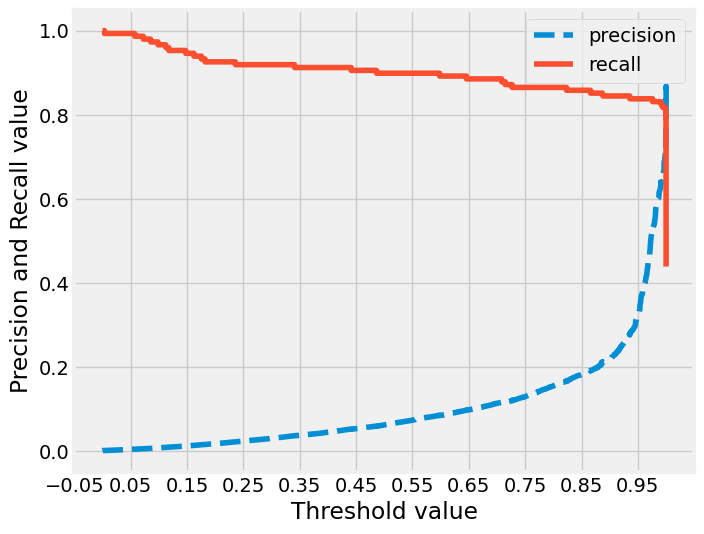

In [39]:
def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    plt.figure(figsize=(8,6))
    plt.style.use('fivethirtyeight')
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.grid
    plt.show()
    
precision_recall_curve_plot( y_test, lr_clf.predict_proba(X_test)[:, 1])

임계값 0.99이하에선 재현율이 매우 좋고 정밀도가 매우 낮다가 0.99이상에선 반대로 나타난다

임계값의 민감도가 너무 심해 올바른 재현율/정밀도 성능을 얻을 수 없음

- LightGBM

In [41]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[85284    11]
 [   32   116]]
정확도: 0.9995, 정밀도: 0.9134, 재현율: 0.7838, F1:0.8436, AUC: 0.9761


이상치만 제거했을 때보다 재현율이 높아졌으나 정밀도는 낮아짐

!! SMOTE를 적용하면 재현율 높아지고 정밀도 낮아지는게 일반적임

따라서, 정밀도보다는 '재현율' 지표를 높이는게 주 목적일 때 쓰는게 좋음